In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))


# Any results you write to the current directory are saved as output.

['sample_submission_ns2btKE.csv', 'train', 'test_ApKoW4T.csv']


In [2]:
train = pd.read_csv('../input/train/train.csv')
train.head()

,image,category
0,2823080.jpg,1
1,2870024.jpg,1
2,2662125.jpg,2
3,2900420.jpg,3
4,2804883.jpg,2


In [3]:
! pip install pretrainedmodels


    100% |████████████████████████████████| 61kB 5.7MB/s ta 0:00:011
  Stored in directory: /tmp/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
Successfully built pretrainedmodels
You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [4]:
from fastai import *

In [5]:
from fastai.vision import *
from fastai.basics import *

In [6]:
import numpy as np
import pandas as pd

# Data visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Fastai
from fastai.vision import *
from fastai.metrics import error_rate
from fastai.vision.models import *
from fastai.vision.learner import model_meta
from fastai.torch_core import flatten_model

# PyTorch
import torch
from torchvision.models import *
import pretrainedmodels

from pathlib import Path
import sys

In [7]:
path= Path('../input/train/')

In [8]:
tfms=get_transforms(do_flip=False,flip_vert=True,max_rotate=10)
tfms

([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-10, 10)}, p=0.75, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (1.0, 1.1), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0.75, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.4, 0.6)}, p=0.75, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.8, 1.25)}, p=0.75, resolved={}, do_run=True, is_random=True)],
 [RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True)])

In [9]:
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=False, reduction='elementwise_mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduction = reduction

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduction is None:
            return F_loss
        else:
            return torch.mean(F_loss)

In [10]:
data = (ImageList .from_csv(path, folder='images', csv_name='train.csv', cols='image')
       #.use_partial_data(sample_pct = .1, seed= 34)
       .split_by_rand_pct(valid_pct=0.1, seed=34)
       .label_from_df(cols='category')
        .add_test_folder(Path('../input/test_ApKoW4T.csv'))
       .transform(tfms, size = (224,224))
       .databunch(bs=16)).normalize(imagenet_stats)

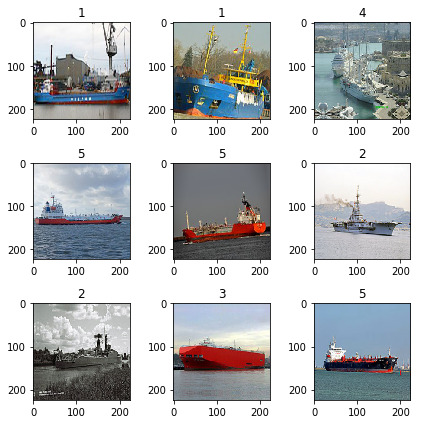

In [11]:
data.show_batch(3, figsize=(6,6), hide_axis=False)

In [12]:
def arch_summary(arch):
    model = arch(False)
    tot = 0
    for i, l in enumerate(model.children()):
        n_layers = len(flatten_model(l))
        tot += n_layers
        print(f'({i}) {l.__class__.__name__:<12}: {n_layers:<4}layers (total: {tot})')

In [15]:
def vgg19Bn(pretrained=False):
    pretrained = 'imagenet' if pretrained else None
    model = pretrainedmodels.vgg19_bn(pretrained=pretrained)
    return model

def resnext(pretrained=False):
    pretrained = 'imagenet' if pretrained else None
    model = pretrainedmodels.resnext101_32x4d(pretrained=pretrained)
    return model

def se_resnet50(pretrained=False):
    pretrained = 'imagenet' if pretrained else None
    model = pretrainedmodels.se_resnet50(pretrained=pretrained)
    return model

def inceptionResNetV2(pretrained=False):
    pretrained = 'imagenet' if pretrained else None
    model = pretrainedmodels.inceptionresnetv2(pretrained=pretrained)
    return model

def xception(pretrained=False):
    pretrained = 'imagenet' if pretrained else None
    model = pretrainedmodels.xception(pretrained=pretrained)
    return model

def pnasnet5large(pretrained=False):
    pretrained = 'imagenet' if pretrained else None
    model = pretrainedmodels.pnasnet5large(pretrained=pretrained)
    return model

In [17]:
import os
model_dir="/tmp/model/"
if not os.path.exists ("/tmp/model/"):
    !mkdir "/tmp/model/"
learn = cnn_learner(data,models.densenet201,model_dir="/tmp/model/",metrics=[FBeta(beta=1),accuracy])

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /tmp/.torch/models/densenet201-c1103571.pth
81131730it [00:01, 62772958.27it/s]


In [ ]:
#arch_summary(pnasnet5large)

In [18]:
learn.loss_fn = FocalLoss()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.63E-03


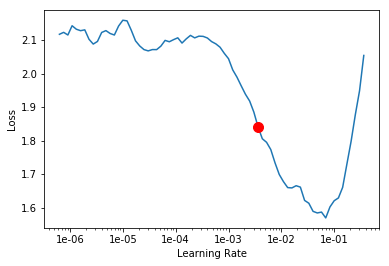

In [19]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [20]:
learn.fit_one_cycle(5,1e-3)

epoch,train_loss,valid_loss,f_beta,accuracy,time
0,0.534759,0.276575,0.896166,0.892800,01:37
1,0.314982,0.152766,0.955789,0.950400,01:36
2,0.177313,0.119388,0.968263,0.964800,01:35
3,0.124502,0.098725,0.965819,0.963200,01:34
4,0.084814,0.095192,0.967239,0.963200,01:34


/opt/conda/lib/python3.6/site-packages/fastai/metrics.py:179: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")
/opt/conda/lib/python3.6/site-packages/fastai/metrics.py:179: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")
/opt/conda/lib/python3.6/site-packages/fastai/metrics.py:179: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")
/opt/conda/lib/python3.6/site-packages/fastai/metrics.py:179: UserWarning: average=`binary` was s

In [22]:
learn.save("stage0")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07


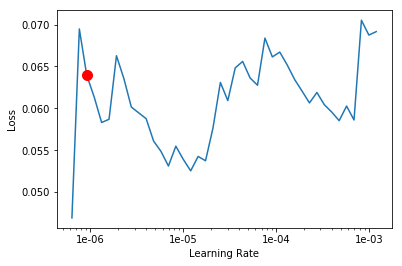

In [21]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [23]:
learn.fit_one_cycle(5,max_lr=1e-6)

epoch,train_loss,valid_loss,f_beta,accuracy,time
0,0.069836,0.104046,0.962045,0.958400,01:34
1,0.068607,0.100293,0.963987,0.960000,01:33
2,0.083274,0.091734,0.973951,0.971200,01:33
3,0.085139,0.088472,0.975838,0.972800,01:34
4,0.076511,0.091514,0.972594,0.969600,01:34


/opt/conda/lib/python3.6/site-packages/fastai/metrics.py:179: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")
/opt/conda/lib/python3.6/site-packages/fastai/metrics.py:179: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")
/opt/conda/lib/python3.6/site-packages/fastai/metrics.py:179: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")
/opt/conda/lib/python3.6/site-packages/fastai/metrics.py:179: UserWarning: average=`binary` was s

In [24]:
learn.save("stage1")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-06


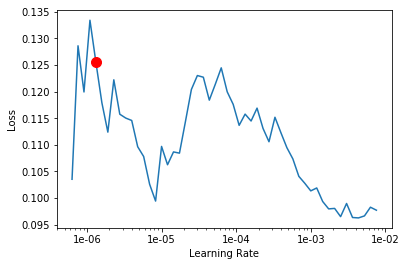

In [25]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [26]:
lr = 1e-6
learn.fit_one_cycle(7,max_lr=1e-6)

epoch,train_loss,valid_loss,f_beta,accuracy,time
0,0.088426,0.096233,0.966817,0.963200,01:33
1,0.086126,0.094497,0.968725,0.964800,01:33
2,0.099239,0.117536,0.963044,0.956800,01:34
3,0.091255,0.086265,0.975838,0.972800,01:34
4,0.077316,0.100915,0.966546,0.961600,01:32
5,0.087957,0.091184,0.968054,0.964800,01:32
6,0.097984,0.087427,0.975423,0.972800,01:31


/opt/conda/lib/python3.6/site-packages/fastai/metrics.py:179: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")
/opt/conda/lib/python3.6/site-packages/fastai/metrics.py:179: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")
/opt/conda/lib/python3.6/site-packages/fastai/metrics.py:179: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")
/opt/conda/lib/python3.6/site-packages/fastai/metrics.py:179: UserWarning: average=`binary` was s

In [28]:
learn.save("Stage2")

In [29]:
learn.load("Stage2")

Learner(data=ImageDataBunch;

Train: LabelList (5627 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
1,1,2,3,2
Path: ../input/train;

Valid: LabelList (625 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
2,4,5,3,2
Path: ../input/train;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: ../input/train, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07


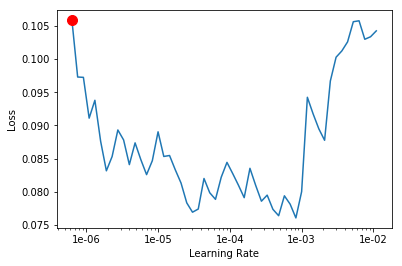

In [30]:
#learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
#learn.fit_one_cycle(5,slice(1e-5))

In [ ]:
#learn.save('stage3')

In [ ]:
# SZ=224
# cutout_frac = 0.25
# p_cutout = 0.5
# cutout_sz = round(SZ*cutout_frac)
# cutout_tfm = cutout(n_holes=(1,1), length=(cutout_sz, cutout_sz), p=p_cutout)

In [ ]:
# data = (ImageList .from_csv(path, folder='images', csv_name='train.csv', cols='image')
#        #.use_partial_data(sample_pct = .1, seed= 34)
#        .split_by_rand_pct(valid_pct=0.1, seed=34)
#        .label_from_df(cols='category')
#         .add_test_folder(Path('../input/test_ApKoW4T.csv'))
#         .transform(get_transforms(xtra_tfms=[cutout_tfm]),size=(224,224))
#        .databunch(bs=32)).normalize(imagenet_stats)
# learn.data = data

In [ ]:
# learn.unfreeze()
# learn.lr_find()
# learn.recorder.plot(suggestion=True)

In [ ]:
# learn.fit_one_cycle(10,slice(1e-6))

In [ ]:
# learn.save('ResNext_Part3')

In [31]:
t  = pd.read_csv('../input/test_ApKoW4T.csv')
t.shape[0]

2680

In [32]:
data.add_test(items=[path/'images'/i for i in t['image'].tolist()],label=None)

In [33]:
data.test_dl

DeviceDataLoader(dl=<torch.utils.data.dataloader.DataLoader object at 0x7f3890bf3160>, device=device(type='cuda'), tfms=[functools.partial(<function _normalize_batch at 0x7f38c4d26f28>, mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]), do_x=True, do_y=False)], collate_fn=<function data_collate at 0x7f38cbeee730>)

In [ ]:
preds, y = learn.TTA(beta=0.4,ds_type=DatasetType.Test)

In [ ]:
preds.shape

In [ ]:
imgName = t['image'].tolist()
imgName

In [ ]:
preds_  = torch.argmax(preds,1)+1
preds_

In [ ]:
preds_ = preds_.numpy()
preds_

In [ ]:
pd.Series(preds_).value_counts()

In [ ]:
predsDF = pd.DataFrame()
predsDF['image'] = imgName
predsDF['category'] = preds_
predsDF.head(20)

In [ ]:
t.head(20)

In [ ]:
sum(predsDF['image'] == t['image']) == t.shape[0]

In [ ]:
predsDF.to_csv('preds_DenseNet201.csv',index=False)
from IPython.display import FileLink, FileLinks
FileLink('preds_DenseNet201.csv')